In [1]:
%matplotlib inline

from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.productivity import *
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load

from random import choice
import numpy as np
import scipy as sp

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [2]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']

load.load_all_publications(asst_faculty, dblp_dir)

## Profile the Schools

Pre-compute all information that we'll need in order to match pairs of schools

In [3]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
def publication_data(function = np.average, five_years_post_hire=False):
    pubs_by_inst = {}
    prestige_map = {}
    for (name, inst_data) in inst.items():
        if name in ignore:
            continue
        current_faculty = faculty_at_institution(name, asst_faculty)
        n_pubs = []
        for person in current_faculty:
            start = person.first_asst_job_year
            end = person.first_asst_job_year + 5
            if person.__contains__('dblp_pubs'):
                contribution = 0
                for pub in person.dblp_pubs:
                    if five_years_post_hire and pub['year'] > end:
                        continue
                    if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                        contribution += inflation_adjust(pub['year'])
                n_pubs.append(contribution)

        pubs_by_inst[name] = {"total_pubs_by_author": function(n_pubs), "status": inst_data['private'], "rank": inst_data['pi']} 
        prestige_map[inst_data['pi']] = name
    
    return (pubs_by_inst, prestige_map)

pubs_by_inst, prestige_map = publication_data(five_years_post_hire=True)

In [4]:
#sorted_prestige_keys = sorted(prestige_map.keys())
#sorted_prestige_names = [prestige_map[key] for key in sorted_prestige_keys]
#top = sorted_prestige_names[:10]

## Match Them

In [5]:
# How many private schools are there? How many public schools are there?
public = [(name, data) for (name, data) in pubs_by_inst.items() if data['status'] == 0 if data['rank'] > 10]
private = [(name, data) for (name, data) in pubs_by_inst.items() if data['status'] == 1 if data['rank'] > 10]

In [6]:
print("There are %d public schools and %d private schools (%d total)." % (len(public), len(private), len(public)+len(private)))

There are 150 public schools and 45 private schools (195 total).


In [7]:
def get_matched_pairs(public, private, skip=0.0):
    pairs = []
    scores = []
    
    available = {}
    for name, _ in public:
        available[name] = True
    
    possible_matches = len(private)
    grab = (1-skip)*possible_matches
    num_matches = 0
    
    # Go through all private schools
    for p1, p1_data in private:
        best_score = np.inf
        
        best_match = ""
        # Find a matching public school
        for p2, p2_data in public:
            # Only consider this school if we haven't already deleted it
            if available.has_key(p2):
                # Match on rank
                score = abs(p2_data["rank"] - p1_data["rank"])
                if score < best_score:
                    best_match = p2
                    best_score = score
        
        del available[best_match]
        pairs.append((p1, best_match))
        scores.append(best_score)
 
        num_matches += 1
        if num_matches > grab:
            break
                
    return pairs, scores

In [8]:
np.random.shuffle(private)
pairs, scores = get_matched_pairs(public, private, skip=0.9)
for i, (p1, p2) in enumerate(pairs):
    print '%s (%s)\t<-->\t%s (%s)\tScore: %f' % (p1, "Private", p2, "Public", scores[i])
print "Total number of matches made: %d" % (len(pairs))

Long Island University (Private)	<-->	University of Southern Mississippi (Public)	Score: 0.600000
Catholic University of America (Private)	<-->	Clemson University (Public)	Score: 0.410000
Duke University (Private)	<-->	University of North Carolina, Chapel Hill (Public)	Score: 0.950000
Drexel University (Private)	<-->	Oregon State University (Public)	Score: 0.350000
University of Southern California (Private)	<-->	University of Rochester (Public)	Score: 0.530000
Total number of matches made: 5


In [9]:
total_trials = 0
num_positive = 0
advantages = []
diffs = []
rank_diffs = []

for time in xrange(300):
    # Shuffle the private schools so we aren't always making the same matches
    np.random.shuffle(private)
    
    pairs,_ = get_matched_pairs(public, private, skip=0.7)
    for p1, p2 in pairs:
        # Who published more? Was this a private university?
        assert inst[p1]['private'] == 1
        assert inst[p2]['private'] == 0
        
        private_university = 0
        published_more = np.argmax([pubs_by_inst[p1]["total_pubs_by_author"], pubs_by_inst[p2]["total_pubs_by_author"]])
        
        diff = pubs_by_inst[p1]["total_pubs_by_author"] - pubs_by_inst[p2]["total_pubs_by_author"]
        diffs.append(diff)
        
        rank_diff = pubs_by_inst[p1]["rank"] - pubs_by_inst[p2]["rank"]
        rank_diffs.append(rank_diff)
        
        if private_university == published_more:
            num_positive += 1
            advantages.append(diff)
        total_trials += 1
    
print sp.stats.binom_test(num_positive, total_trials, .5, alternative='two-sided')

0.00910658004865


Ttest_1sampResult(statistic=5.9290676974596694, pvalue=3.2914004206812327e-09)
0.0790452380952


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


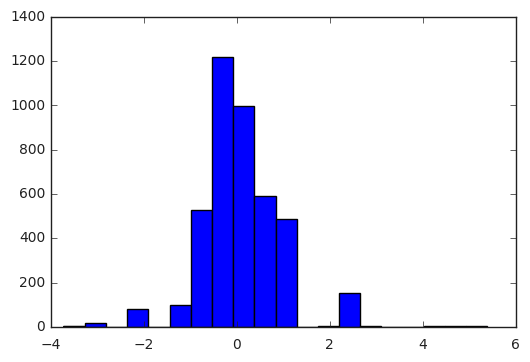

In [10]:
plt.hist(rank_diffs, bins=20)

print sp.stats.ttest_1samp(rank_diffs, popmean=0)
print np.average(rank_diffs)
plt.show()

In [11]:
print float(num_positive) / total_trials

0.479761904762


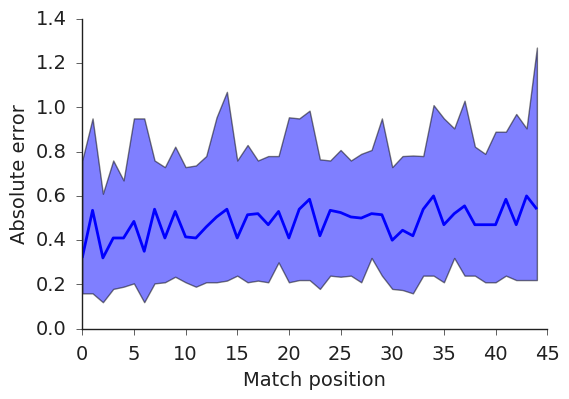

In [13]:
T = 100
scores = np.zeros((T, len(private)), dtype=float)

for t in xrange(T):
    np.random.shuffle(private)
    _, s = get_matched_pairs(public, private)
    scores[t, :] = np.array(s)

fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
ylo = np.percentile(scores, 25, axis=0)
yhi = np.percentile(scores, 75, axis=0)

ax.fill_between(xrange(len(ylo)), ylo, yhi, alpha=0.5)
ax.plot(np.median(scores, axis=0), lw=LINE_WIDTH)

ax.set_xlabel('Match position')
ax.set_ylabel('Absolute error')
finalize(ax)
plt.show()